In [23]:
# Import libraries
print("Importing libraries...")
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

Importing libraries...


In [24]:
# Setting investment universe
stock_basket = []
while True:
    add_stock = input('Enter a stock ticker symbol to be added to your portfolio, or type Exit to proceed to the next step.\n')
    if add_stock.upper() == 'EXIT':
        break
    else: # Gathering 1-day data to check that input ticker is valid
        data = yf.download(add_stock, start = '2024-07-29', end = '2024-07-30')
        if data.empty:
            print('Invalid ticker input. Please enter a valid ticker or type Exit to proceed to the next step.')
        else:
            stock_basket.append(add_stock)
print(f'Selected stocks: {stock_basket}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Selected stocks: ['MSFT', 'NVDA', 'AAPL', 'GOOGL']


In [25]:
# Setting date range
start_date = input('Enter the start date for the date range in YYYY-MM-DD format.\n')
end_date = input('Enter the end date for the date range in YYYY-MM-DD format.\n')

# Download all ticker data
data = yf.download(stock_basket, start = start_date, end = end_date)
close = data['Close']
close.tail()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2024-12-24,257.916443,196.110001,439.329987,140.220001
2024-12-26,258.735504,195.600006,438.109985,139.929993
2024-12-27,255.309296,192.759995,430.529999,137.009995
2024-12-30,251.923019,191.240005,424.829987,137.490005
2024-12-31,250.144974,189.300003,421.500000,134.289993


In [26]:
# Setting fixed weights, experiment with floating weights later
w = []
for stock in stock_basket:
    weight = input(f'Enter the fixed portfolio weight (as a decimal) to assign to {stock}. As this is a long-only portfolio, ensure that weights sum to 1.\n')
    # Need to write code here that addresses error with float(weight) e.g., alphanumeric input
    while not (float(weight) < 1 and float(weight) > 0):
        weight = input(f'Invalid entry. Enter the fixed portfolio weight (as a decimal) to assign to {stock}.')
    w.append(float(weight))
w = np.array(w)
if np.sum(w) == float(1):
    print('Portfolio Weights:')
else:
    print('Auto-scaling input portfolio weights such that they sum to 1.')
    w = w/np.sum(w)
    print('Scaled Portfolio Weights:')
weights = pd.Series(data = w, index = stock_basket).sort_index()
print(weights)

Auto-scaling input portfolio weights such that they sum to 1.
Scaled Portfolio Weights:
AAPL     0.2
GOOGL    0.1
MSFT     0.4
NVDA     0.3
dtype: float64


In [27]:
# Setting time horizon
while True:
    horizon = input('Enter the time horizon for which to calculate VaR. Enter `Day` for 1-Day VaR, `Week` for 1-Week VaR, or `Month` for 1-Month VaR.')
    if horizon.upper() == 'DAY':
        h = 1
        print(f'Selected time horizon: 1 {horizon.lower()}.')
        break
    elif horizon.upper() == 'WEEK':
        h = 5
        print(f'Selected time horizon: 1 {horizon.lower()}, or approximately {h} trading days.')
        break
    elif horizon.upper() == 'MONTH':
        h = 21
        print(f'Selected time horizon: 1 {horizon.lower()}, or approximately {h} trading days.')
        break
    else:
        print('Invalid input. Please try again.\n')

Selected time horizon: 1 day.


In [28]:
# Setting confidence interval
while True:
    ci = input('Enter the desired confidence level as a decimal between 0 and 1 exclusive. For example, enter `0.99` for a 99% confidence level.')
    # Need to write code here that addresses error with float(ci) e.g., alphanumeric input
    if float(ci) > 0 and float(ci) < 1:
        z = stats.norm.ppf(1 - (1 - float(ci))/2)
        print(f'Confidence Interval: {float(ci)*100}%')
        print(f'Two-tailed z-score: {round(z, 3)}')
        break
    else:
        print('Invalid input. Please try again.\n')

Confidence Interval: 99.0%
Two-tailed z-score: 2.576


In [29]:
# Setting portfolio value
V = float(input('Finally, enter the portfolio value in dollars.'))

Average Daily Portfolio Return: 0.204%
Portfolio Standard Deviation: 1.527%


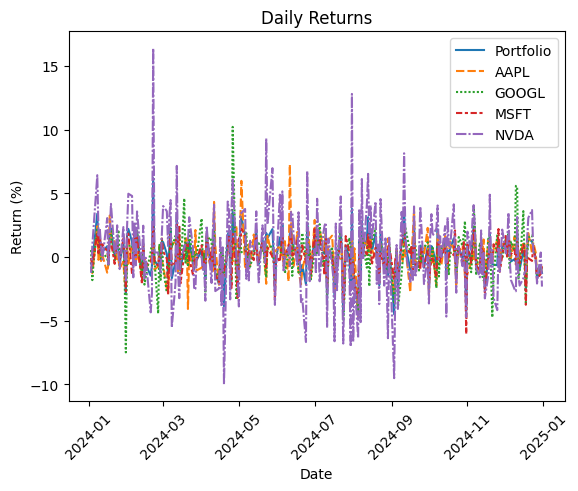

In [30]:
# Computing and plotting returns
returns = close.pct_change().dropna()
daily_portfolio_returns = returns.multiply(weights, axis=1).sum(axis = 1)
daily_portfolio_returns.name = 'Portfolio'
all_data = pd.concat([daily_portfolio_returns, returns], axis = 1)

r_p = daily_portfolio_returns.mean()
print(f'Average Daily Portfolio Return: {round(r_p*100, 3)}%')
weights_np = weights.to_numpy()
Sigma_np = returns.cov().to_numpy()
Var_p = (weights_np @ Sigma_np) @ weights_np.T
sigma_p = np.sqrt(Var_p)
print(f'Portfolio Standard Deviation: {round(sigma_p*100, 3)}%')

plt.figure(1)
sns.lineplot(all_data*100)
plt.title('Daily Returns')
plt.xticks(rotation = 45)
plt.ylabel('Return (%)')
plt.show()

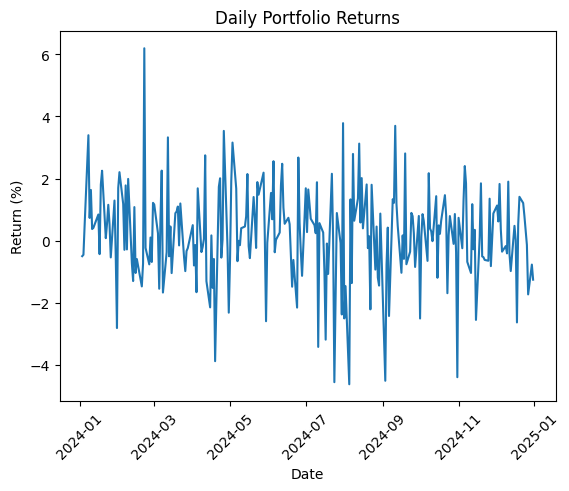

In [31]:
plt.figure(2)
sns.lineplot(daily_portfolio_returns*100)
plt.title('Daily Portfolio Returns')
plt.xticks(rotation = 45)
plt.ylabel('Return (%)')
plt.show()

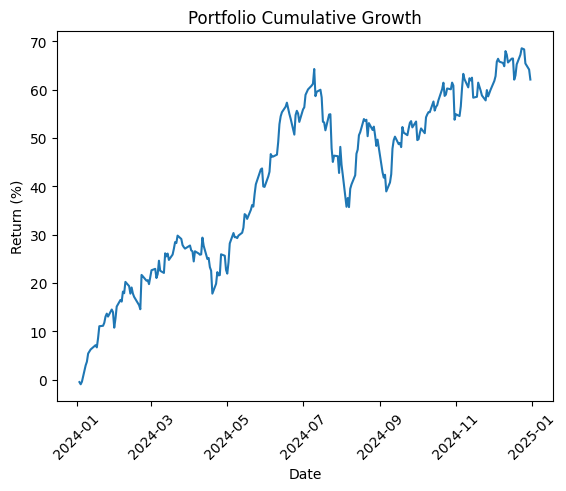

In [32]:
plt.figure(3)
sns.lineplot(((1+daily_portfolio_returns).cumprod() - 1)*100)
plt.title('Portfolio Cumulative Growth')
plt.xticks(rotation = 45)
plt.ylabel('Return (%)')
plt.show()

In [33]:
# Variance-Covariance Method
def VCov_VaR(returns_df, weights_df):
    daily_portfolio_returns = returns_df.multiply(weights_df, axis=1).sum(axis = 1)
    r_p = daily_portfolio_returns.mean()
    print(f'Average Daily Portfolio Return: {round(r_p*100, 3)}%')
    weights_np = weights_df.to_numpy()
    Sigma_np = returns_df.cov().to_numpy()
    Var_p = (weights_np @ Sigma_np) @ weights_np.T
    sigma_p = np.sqrt(Var_p)
    print(f'Portfolio Standard Deviation: {round(sigma_p*100, 3)}%')

    VaR = (r_p - sigma_p*z)*V*np.sqrt(h)
    ES = daily_portfolio_returns[daily_portfolio_returns < -(r_p - sigma_p*z)*np.sqrt(h)].mean()*V
    print(f'1-{horizon.capitalize()} {round(float(ci)*100, 1)}% VaR for a ${round(V, 0):,} portfolio: ${round(np.abs(VaR), 2):,}')
    print(f'1-{horizon.capitalize()} {round(float(ci)*100, 1)}% Expected Shortfall for a ${round(V, 0):,} portfolio: ${round(np.abs(ES), 2):,}')
    return VaR, ES

In [34]:
# Historical Method
def hist_VaR(returns_df, weights_df):
    daily_return_series = returns_df.multiply(weights_df, axis=1).sum(axis = 1)
    sorted_returns = daily_return_series.sort_values(ascending=True)
    n = len(sorted_returns)
    rank = round(n*(1 - float(ci)), 0)
    r_rank = sorted_returns.iloc[int(rank) - 1]
    print(f'Computing VaR using the #{int(rank)} worst portfolio return of {round(r_rank*100, 3)}%')

    VaR = r_rank*V*np.sqrt(h)
    ES = sorted_returns[sorted_returns < -r_rank*np.sqrt(h)].mean()*V
    print(f'1-{horizon.capitalize()} {round(float(ci)*100, 1)}% VaR for a ${round(V, 0):,} portfolio: ${round(np.abs(VaR), 2):,}')
    print(f'1-{horizon.capitalize()} {round(float(ci)*100, 1)}% Expected Shortfall for a ${round(V, 0):,} portfolio: ${round(np.abs(ES), 2):,}')
    return VaR, ES

In [35]:
# Monte Carlo Simulation Method
def MCS_VaR(price_series, weights_df, seed_num):
    log_rets = np.log(price_series/price_series.shift()).dropna()
    n = int(input('Enter the integer number of simulated prices to generate for each stock.'))
    print(f'Simulating {n} prices for each stock.')

    np.random.seed(seed_num)
    rand_uncorr = pd.DataFrame(np.random.randn(n, len(stock_basket)), columns=sorted(stock_basket)) # Randomly drawn values uncorrelated across assets
    cholesky = np.linalg.cholesky(log_rets.corr())
    W_t = (cholesky @ rand_uncorr.T).T # Assets are now correlated
    W_t.columns = sorted(stock_basket)

    t = pd.Series(range(1, n+1))/n

    S_0 = price_series.tail(1).squeeze()

    r_f = float(input('Enter the risk-free rate as a decimal. For example, a risk-free rate of 4% should be entered as 0.04.'))
    print(f'Risk-Free Rate of {round(r_f*100, 3)}% as proxy for expected return for all assets (risk-neutral valuation).')
    mu = pd.Series(np.ones(len(stock_basket))*r_f, index = sorted(stock_basket))

    sigma = log_rets.std()
    
    sim_prices = S_0*np.exp(pd.DataFrame(t.values[:, np.newaxis]*(mu - (sigma**2)/2).values, columns = sorted(stock_basket)) + W_t*sigma)
    
    sim_log_rets = np.log(sim_prices/sim_prices.shift()).dropna()
    sim_daily_portfolio_returns = sim_log_rets.multiply(weights_df, axis = 1).sum(axis = 1)
    
    VaR, ES = hist_VaR(returns_df = sim_log_rets, weights_df = weights)

    plt.figure()
    sns.lineplot(sim_daily_portfolio_returns*100)
    plt.title('Simulated Daily Portfolio Returns')
    plt.xticks(rotation = 45)
    plt.ylabel('Return (%)')
    plt.show()
    return VaR, ES

Variance-Covariance Method
Average Daily Portfolio Return: 0.204%
Portfolio Standard Deviation: 1.527%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,286.78
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,658.07
Historical Method
Computing VaR using the #3 worst portfolio return of -4.508%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $45,084.37
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,802.82
Monte Carlo Simulation Method


Simulating 100 prices for each stock.
Risk-Free Rate of 4.0% as proxy for expected return for all assets (risk-neutral valuation).
Computing VaR using the #1 worst portfolio return of -5.998%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $59,979.08
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $192.78


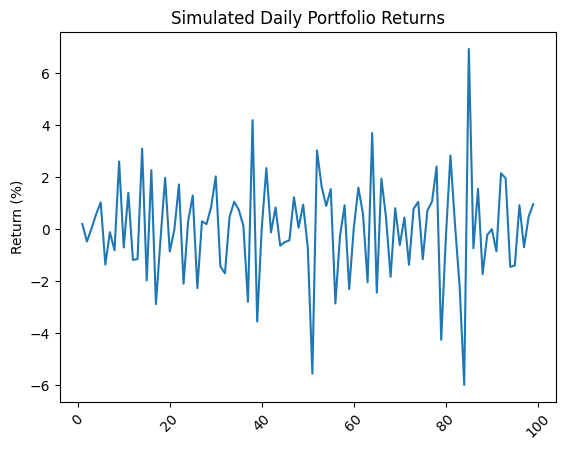

In [36]:
# Calculating using each method
print('Variance-Covariance Method')
vcov_VaR, vcov_ES = VCov_VaR(returns_df = returns, weights_df = weights)

print('Historical Method')
h_VaR, h_ES = hist_VaR(returns_df = returns, weights_df = weights)

print('Monte Carlo Simulation Method')
mc_VaR, mc_ES = MCS_VaR(price_series = close, weights_df = weights, seed_num = 1)

Scenario Analysis for Stress Testing

In [37]:
def ShockSeries(return_series, return_shock, vol_shock):
        adjusted_returns = returns * (1 - return_shock)
        for stock in adjusted_returns.columns:
            adjusted_returns[stock] += np.random.normal(0, returns[stock].std() * vol_shock, len(returns))
        return adjusted_returns

In [ ]:
def ScenarioAnalysis():

    return_shock_list = np.arange(0, 0.55, 0.05)
    print(return_shock_list)

    var_list = []
    es_list = []

    for shock in return_shock_list:
        shocked_returns = ShockSeries(return_series = returns, return_shock = shock, vol_shock = 0)
        shocked_daily_portfolio_returns = shocked_returns.multiply(weights, axis=1).sum(axis = 1)
        shocked_daily_portfolio_returns.name = 'Shocked Portfolio'
        print(f'\nFor a sudden {round(shock*100, 1)}% drop in the stock market (or equivalent increase in interest rates):')
        var, es = VCov_VaR(returns_df = shocked_returns, weights_df = weights)
        var_list.append(np.abs(var))
        es_list.append(np.abs(es))

    plt.figure()
    plt.plot([shock * 100 for shock in return_shock_list], var_list, label='VaR')
    plt.plot([shock * 100 for shock in return_shock_list], es_list, label='ES')
    plt.xlabel('Shock (%)')
    plt.ylabel('$')
    plt.title('Stress Testing VaR and ES for Return Shock')
    plt.legend()
    plt.grid(True)
    plt.show()


    vol_shock_list = np.arange(0, 0.55, 0.05)
    print(vol_shock_list)
    
    var_list = []
    es_list = []

    for shock in vol_shock_list:
        shocked_returns = ShockSeries(return_series = returns, return_shock = 0, vol_shock = shock)
        shocked_daily_portfolio_returns = shocked_returns.multiply(weights, axis=1).sum(axis = 1)
        shocked_daily_portfolio_returns.name = 'Shocked Portfolio'
        print(f'\nFor a sudden {round(shock*100, 1)}% increase in volatility:')
        var, es = VCov_VaR(returns_df = shocked_returns, weights_df = weights)
        var_list.append(np.abs(var))
        es_list.append(np.abs(es))
    
    plt.figure()
    plt.plot([shock * 100 for shock in vol_shock_list], var_list, label='VaR')
    plt.plot([shock * 100 for shock in vol_shock_list], es_list, label='ES')
    plt.xlabel('Shock (%)')
    plt.ylabel('$')
    plt.title('Stress Testing VaR and ES for Volatility Shock')
    plt.legend()
    plt.grid(True)
    plt.show()

VaR Backtesting
Backtesting evaluates the accuracy & effectiveness of the VaR numbers obtained from the various VaR models.

Traffic Light Approach
Notes
1. Used by regulators
2. Mentioned in Basel documents

Steps
1. For last 250 trading days, check how much the portfolio losses were on each day and compare to VaR
2. Breach if loss on a given day > VaR
3. Green Zone (Low Risk): total number of breaches between 0 and 4, no action needed
    Yellow Zone (Moderate Risk): total number of breaches between 5 and 9, increase scrutiny of portfolio strategies and perform daily portfolio monitoring
    Red Zone (High Risk): total number of breaches >= 10, model is inaccurate or there are serious management issues

In [39]:
def TrafficLight():
    # Setting date range
    start_date = (dt.today() - relativedelta(days=400)).strftime("%Y-%m-%d") # Ensuring long enough lookback window to subset from
    end_date = dt.today().strftime("%Y-%m-%d")

    # Download all ticker data
    backtest_data = yf.download(stock_basket, start = start_date, end = end_date)['Close'].tail(251) # 250 trading days of returns

    backtest_returns = backtest_data.pct_change().dropna()
    backtest_daily_portfolio_value = backtest_returns.multiply(weights, axis=1).sum(axis = 1)*V
    backtest_daily_portfolio_value.name = 'Backtest Portfolio ($)'
    comparison_df = pd.DataFrame(backtest_daily_portfolio_value)
    comparison_df['Variance-Covariance'] = comparison_df['Backtest Portfolio ($)'] < vcov_VaR
    comparison_df['Historical'] = comparison_df['Backtest Portfolio ($)'] < h_VaR
    comparison_df['Monte Carlo Simulation'] = comparison_df['Backtest Portfolio ($)'] < mc_VaR

    for VaR_method in comparison_df.columns[1:]:
        total_breaches = comparison_df[VaR_method].sum()
        print(f"Total breaches for the {VaR_method} method in the last 250 trading days: {total_breaches}")
        if total_breaches <= 4:
            color = 'Green'
            action_item = 'No immediate action required.'
        elif total_breaches <= 9:
            color = 'Yellow'
            action_item = 'Increase scrutiny of portfolio strategies and perform daily portfolio monitoring.'
        else:
            color = 'Red'
            action_item = 'Recalibrate model or reassess portfolio management.'
        print(f"As a result, the {VaR_method} model is in the {color} zone. {action_item}")


Kupiec Test
Notes
1. Statistical method for backtesting VaR
2. AKA Proportion of Failure (PoF) Test
3. Checks if number of breaches (losses > VaR) is consistent with CI set up by model (e.g., for 95% Confidence Interval and 1000 trading days of data, alpha = 1-0.95 = 0.05 so alpha*1000 = 50 breaches are allowed)
4. Likelihood Ratio (LR) characteristics
    a. Follows Chi square distribution since we are comparing 2 models by looking at how much more likely data falls under one model vs. other; test statistic (ratio of 2 variances) typically follows Chi square distribution  
    b. 1 degree of freedom since we are testing the single parameter of breach probability
5. p value > 0.05 (results could have occurred by chance) indicates model is performing adequately, p value < 0.05 (statistically significant) indicates model is not performing adequately

Steps
1. Define the parameters (Confidence Interval and Time Horizon)
2. Count number of breaches
3. LR_PoF = -2*ln((p^x * (1-p)^(n-x))/(p_hat^x * (1-p_hat)^(n-x)))
    a. p: expected probability of breach (AKA alpha = 1 - CI)
    b. x: number of breaches
    c. n: number of observations
    d. p_hat: observed probability of breach (x/n)

In [40]:
def Kupiec():
    p = 1 - float(ci)
    n = int(input("How many of the most recent days of trading data would you like to examine?"))
    
    backtest_data = yf.download(stock_basket)['Close'].tail(n+1)
    backtest_returns = backtest_data.pct_change().dropna()
    backtest_daily_portfolio_value = backtest_returns.multiply(weights, axis=1).sum(axis = 1)*V
    backtest_daily_portfolio_value.name = 'Backtest Portfolio ($)'
    comparison_df = pd.DataFrame(backtest_daily_portfolio_value)
    comparison_df['Variance-Covariance'] = comparison_df['Backtest Portfolio ($)'] < vcov_VaR
    comparison_df['Historical'] = comparison_df['Backtest Portfolio ($)'] < h_VaR
    comparison_df['Monte Carlo Simulation'] = comparison_df['Backtest Portfolio ($)'] < mc_VaR

    for VaR_method in comparison_df.columns[1:]:
        x = comparison_df[VaR_method].sum()
        p_hat = x/n
        numerator = (p**x) * (1-p)**(n-x)
        denominator = (p_hat**x) * (1-p_hat)**(n-x)
        LR = -2*np.log(numerator/denominator)
        p_value = 1 - stats.chi2.cdf(LR, 1) # Right-tailed probability of Chi Square distribution
        if p_value > 0.05:
            print(f"The {VaR_method} model is performing adequately, given a Likelihood Ratio of {round(LR, 3)} and a p-value of {round(p_value, 3)}, which fails to reject the null hypothesis.")
        else:
            print(f"The {VaR_method} model is NOT performing adequately, given a Likelihood Ratio of {round(LR, 3)} and a p-value of {round(p_value, 3)}, which rejects the null hypothesis.")

[*********************100%***********************]  4 of 4 completed


The Variance-Covariance model is NOT performing adequately, given a Likelihood Ratio of 30.934 and a p-value of 0.0, which rejects the null hypothesis.
The Historical model is performing adequately, given a Likelihood Ratio of 0.831 and a p-value of 0.362, which fails to reject the null hypothesis.
The Monte Carlo Simulation model is NOT performing adequately, given a Likelihood Ratio of 13.476 and a p-value of 0.0, which rejects the null hypothesis.


[*********************100%***********************]  4 of 4 completed


Total breaches for the Variance-Covariance method in the last 250 trading days: 6
As a result, the Variance-Covariance model is in the Yellow zone. Increase scrutiny of portfolio strategies and perform daily portfolio monitoring.
Total breaches for the Historical method in the last 250 trading days: 3
As a result, the Historical model is in the Green zone. No immediate action required.
Total breaches for the Monte Carlo Simulation method in the last 250 trading days: 0
As a result, the Monte Carlo Simulation model is in the Green zone. No immediate action required.
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]

For a sudden 0.0% drop in the stock market (or equivalent increase in interest rates):
Average Daily Portfolio Return: 0.204%
Portfolio Standard Deviation: 1.527%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,286.78
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,658.07

For a sudden 5.0% drop in the stock market (or equivalent increase in interest

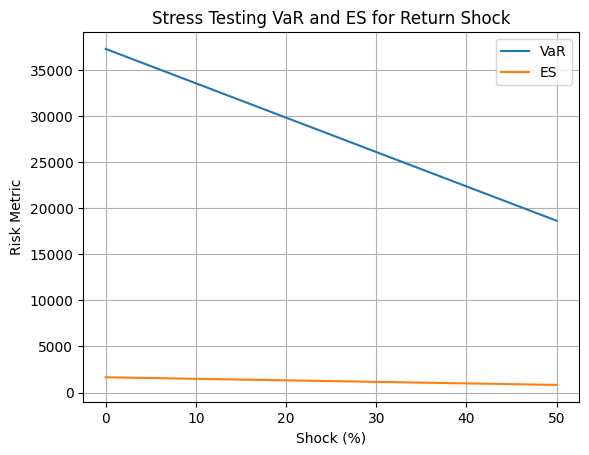

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]

For a sudden 0.0% increase in volatility:
Average Daily Portfolio Return: 0.204%
Portfolio Standard Deviation: 1.527%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,286.78
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,658.07

For a sudden 5.0% increase in volatility:
Average Daily Portfolio Return: 0.2%
Portfolio Standard Deviation: 1.528%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,371.27
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,611.13

For a sudden 10.0% increase in volatility:
Average Daily Portfolio Return: 0.197%
Portfolio Standard Deviation: 1.533%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,510.34
1-Day 99.0% Expected Shortfall for a $1,000,000.0 portfolio: $1,578.61

For a sudden 15.0% increase in volatility:
Average Daily Portfolio Return: 0.226%
Portfolio Standard Deviation: 1.534%
1-Day 99.0% VaR for a $1,000,000.0 portfolio: $37,265.47
1-Day 99.0% Expected Short

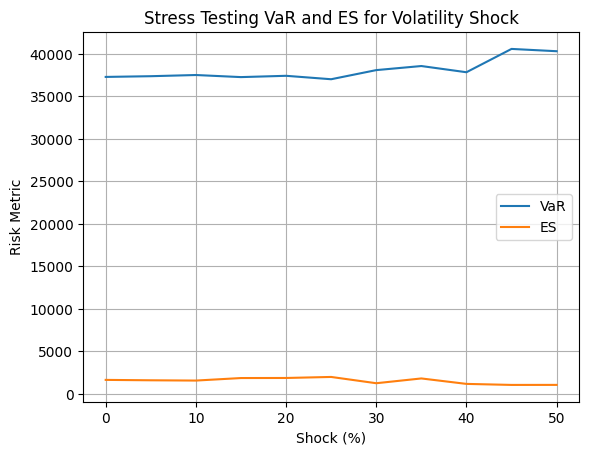

[*********************100%***********************]  4 of 4 completed


The Variance-Covariance model is NOT performing adequately, given a Likelihood Ratio of 30.934 and a p-value of 0.0, which rejects the null hypothesis.
The Historical model is performing adequately, given a Likelihood Ratio of 0.831 and a p-value of 0.362, which fails to reject the null hypothesis.
The Monte Carlo Simulation model is NOT performing adequately, given a Likelihood Ratio of 13.476 and a p-value of 0.0, which rejects the null hypothesis.


In [41]:
# Post-Calc Work
while True:
    action = input("To perform scenario analysis for stress testing, enter 1. To perform backtesting, enter 2. To end, enter anything else.")
    if action == '1':
        ScenarioAnalysis()
    elif action == '2':
        bt_type = input("To backtest using the Traffic Light Approach, enter 1. To backtest using the Kupiec Test, enter anything else.")
        if bt_type == '1':
            TrafficLight()
        else:
            Kupiec()
    else:
        break        